In [22]:
"""Script for optimization of a single topology"""
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt

from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.core.problem import StarmapParallelization
from auto_robot_design.generator.restricted_generator.two_link_generator import TwoLinkGenerator, visualize_constrains

from auto_robot_design.optimization.saver import (
    ProblemSaver, )
from auto_robot_design.description.builder import jps_graph2pinocchio_robot
from auto_robot_design.description.utils import (
    draw_joint_point, )
from auto_robot_design.optimization.problems import CalculateCriteriaProblemByWeigths, get_optimizing_joints
from auto_robot_design.optimization.optimizer import PymooOptimizer
from auto_robot_design.pinokla.calc_criterion import ActuatedMass, EffectiveInertiaCompute, ImfCompute, ManipCompute, MovmentSurface, NeutralPoseMass, TranslationErrorMSE, ManipJacobian
from auto_robot_design.pinokla.criterion_agregator import CriteriaAggregator
from auto_robot_design.pinokla.criterion_math import ImfProjections
from auto_robot_design.pinokla.default_traj import convert_x_y_to_6d_traj_xz, get_simple_spline, get_vertical_trajectory, create_simple_step_trajectory,get_workspace_trajectory
from auto_robot_design.optimization.rewards.reward_base import PositioningReward
from auto_robot_design.optimization.rewards.jacobian_and_inertia_rewards import HeavyLiftingReward, AccelerationCapability, MeanHeavyLiftingReward, MinAccelerationCapability
from auto_robot_design.optimization.rewards.pure_jacobian_rewards import EndPointZRRReward, VelocityReward, ForceEllipsoidReward
from auto_robot_design.optimization.rewards.inertia_rewards import MassReward
from auto_robot_design.description.actuators import TMotor_AK10_9, TMotor_AK60_6, TMotor_AK70_10, TMotor_AK80_64, TMotor_AK80_9
from auto_robot_design.description.builder import ParametrizedBuilder, DetailedURDFCreatorFixedEE, jps_graph2pinocchio_robot

### Parametrization

#### 1) mechanism configuration

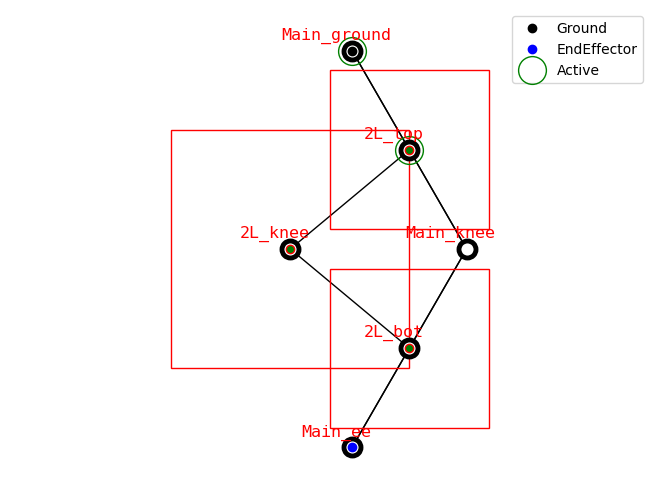

In [23]:
generator = TwoLinkGenerator()
all_graphs = generator.get_standard_set(shift=0.3)
graph, constrain_dict = all_graphs[1]

actuator = TMotor_AK10_9()
thickness = 0.04
builder = ParametrizedBuilder(DetailedURDFCreatorFixedEE, size_ground=np.array(
    [thickness*5, thickness*10, thickness*2]), actuator=actuator,thickness=thickness)
draw_joint_point(graph)
visualize_constrains(graph, constrain_dict)

#### 2) set optimization task

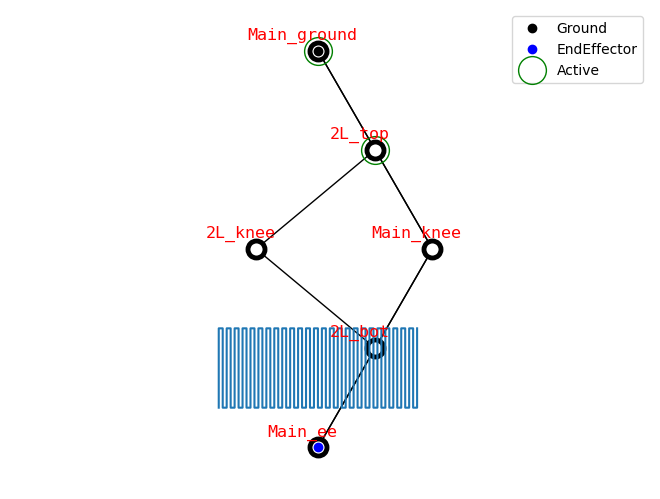

In [24]:
# trajectories
workspace_trajectory = convert_x_y_to_6d_traj_xz(*get_workspace_trajectory([-0.25,-0.9], 0.2, 0.5, 30,50))
# 2) characteristics to be calculated
# criteria that either calculated without any reference to points, or calculated through the aggregation of values from all points on trajectory
dict_trajectory_criteria = {
    "MASS": NeutralPoseMass(),
    "POS_ERR": TranslationErrorMSE()  # MSE of deviation from the trajectory
}
# criteria calculated for each point on the trajectory
dict_point_criteria = {
    # Impact mitigation factorewards_verticalr along the axis
    "IMF": ImfCompute(ImfProjections.Z),
    "MANIP": ManipCompute(MovmentSurface.XZ),
    "Effective_Inertia": EffectiveInertiaCompute(),
    "Actuated_Mass": ActuatedMass(),
    "Manip_Jacobian": ManipJacobian(MovmentSurface.XZ)
}
crag = CriteriaAggregator(dict_point_criteria, dict_trajectory_criteria)

# set the rewards and weights for the optimization task
acceleration_capability = MinAccelerationCapability(manipulability_key='Manip_Jacobian',
            trajectory_key="traj_6d", error_key="error", actuated_mass_key="Actuated_Mass")

heavy_lifting = MeanHeavyLiftingReward(manipulability_key='Manip_Jacobian', trajectory_key="traj_6d", error_key="error", mass_key="MASS")
rewards_vertical = [(PositioningReward(pos_error_key="POS_ERR"), 1),
           #(heavy_lifting, 1/16), 
           (acceleration_capability,1)]


vertical_trajectories = [workspace_trajectory]

rewards_and_trajectories = [(rewards_vertical, vertical_trajectories)]

draw_joint_point(graph)

for _, trajectories in rewards_and_trajectories:
    for trajectory in trajectories:
        plt.plot(trajectory[:,0],trajectory[:,2])

#### Calculate rewards for initial graph.

In [25]:
fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder)

crag = CriteriaAggregator(
    dict_point_criteria, dict_trajectory_criteria)

fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder=builder)
partial_rewards = []
for rewards, trajectories in rewards_and_trajectories:
    max_reward = -float('inf')
    max_partial = None
    best_trajectory = None
    for trajectory_id, trajectory in enumerate(trajectories):
        point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)
        current_total = 0
        current_partial = []
        for reward, weight in rewards:
            current_partial.append(reward.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator=actuator)[0])
            current_total += weight*current_partial[-1]
        if current_total > max_reward:
            max_reward = current_total
            max_partial = current_partial
            best_trajectory_id = trajectory_id

    print('Best trajectory id:', best_trajectory_id, 'partial rewards at best trajectory:', max_partial)

Best trajectory id: 0 partial rewards at best trajectory: [0, 0.36549783]


In [26]:
# activate multiprocessing
N_PROCESS = 16
pool = multiprocessing.Pool(N_PROCESS)
runner = StarmapParallelization(pool.starmap)

# the result is the dict with key - joint_point, value - tuple of all possible coordinate moves
optimizing_joints = get_optimizing_joints(graph, constrain_dict)

In [27]:
population_size = 32
n_generations = 60

# create the problem for the current optimization
problem = CalculateCriteriaProblemByWeigths(graph,builder=builder,
                                            jp2limits=optimizing_joints,
                                            crag = crag,
                                            rewards_and_trajectories=rewards_and_trajectories,
                                            elementwise_runner=runner, Actuator = actuator)

saver = ProblemSaver(problem, "test", True)
saver.save_nonmutable()
algorithm = PSO(pop_size=population_size, save_history=True)
optimizer = PymooOptimizer(problem, algorithm, saver)

res = optimizer.run(
    True, **{
        "seed": 1,
        "termination": ("n_gen", n_generations),
        "verbose": True
    })


     1 |       32 |        - |       - |  0.9000 |  2.00000 |  2.00000 | -1.470928E-01 | -2.985434E-01
     2 |       64 |  0.18802 |       3 |  0.5208 |  2.00000 |  2.01684 | -2.332357E-01 | -2.992435E-01
     3 |       96 |  0.16750 |       3 |  0.5075 |  1.99177 |  2.03083 | -2.791275E-01 | -3.467221E-01
     4 |      128 | -2.8E-02 |       3 |  0.3827 |  1.98100 |  2.04627 | -3.099298E-01 | -3.595952E-01
     5 |      160 | -2.7E-02 |       3 |  0.3831 |  1.96815 |  2.05616 | -3.243155E-01 | -3.665470E-01
     6 |      192 |  0.00734 |       3 |  0.4046 |  1.95690 |  2.06396 | -3.373287E-01 | -3.811494E-01
     7 |      224 | -2.2E-02 |       3 |  0.3861 |  1.94778 |  2.07694 | -3.446767E-01 | -3.841977E-01
     8 |      256 |  0.01992 |       3 |  0.4125 |  1.93688 |  2.08603 | -3.578831E-01 | -3.947124E-01
     9 |      288 |  0.37847 |       2 |  0.6407 |  1.96341 |  2.04229 | -3.680116E-01 | -4.084491E-01
    10 |      320 | -1.3E-02 |       3 |  0.3917 |  1.96154 |  2.06350 | 

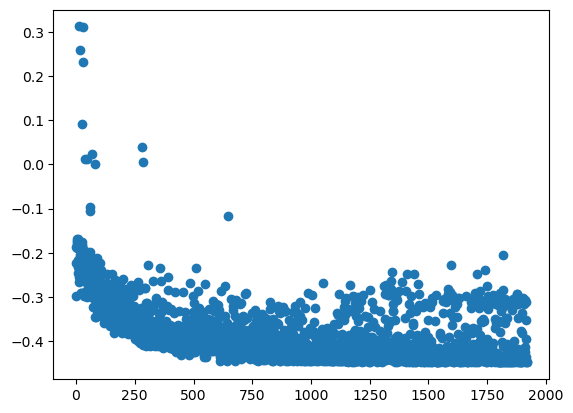

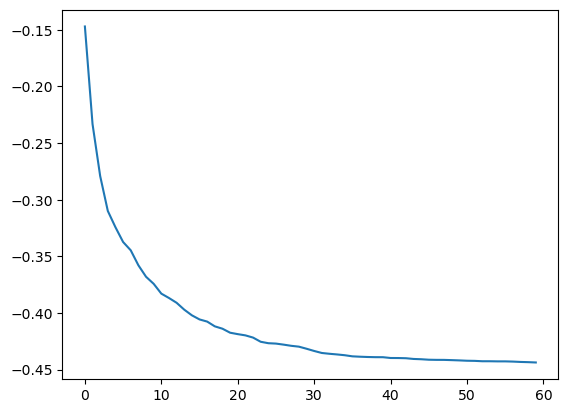

In [28]:
flatten_history = np.array(optimizer.history["F"]).flatten()
history_mean = np.array(optimizer.history["Mean"])
plt.scatter(np.arange(len(flatten_history)),flatten_history)
plt.show()
plt.plot(np.arange(len(history_mean)),history_mean)
plt.show()

In [29]:
worst_id = np.argmax(optimizer.history["F"])
worst_reward = optimizer.history["F"][worst_id]
print('The maximum result in optimization task:', worst_reward.item())

The maximum result in optimization task: 0.31260867278793075


The minimum result in optimization task: [-0.44864756]


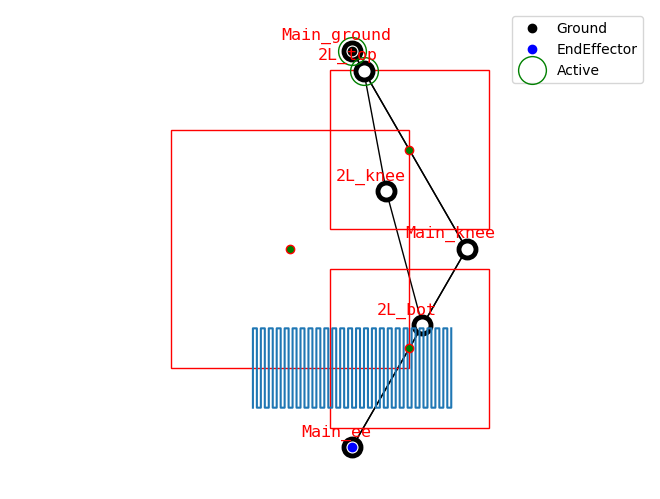

In [30]:
best_id = np.argmin(optimizer.history["F"])
best_x = optimizer.history["X"][best_id]
best_reward = optimizer.history["F"][best_id]
print("The minimum result in optimization task:", best_reward)

problem.mutate_JP_by_xopt(best_x)
draw_joint_point(problem.graph)

problem.mutate_JP_by_xopt(problem.initial_xopt)
for _, trajectories in rewards_and_trajectories:
    for trajectory in trajectories:
        plt.plot(trajectory[:,0],trajectory[:,2])
visualize_constrains(problem.graph, constrain_dict)


In [31]:
best_reward_decomposition = optimizer.history["Fs"][best_id]
best_reward_decomposition

array([[0.        , 0.        , 0.44864756]])

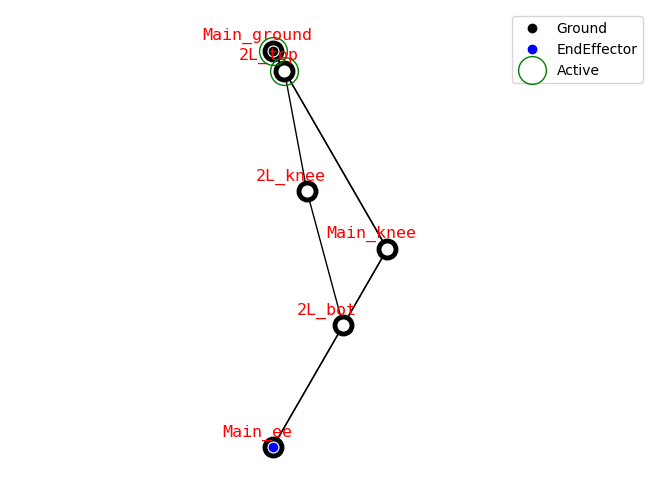

In [32]:
problem.mutate_JP_by_xopt(best_x)
draw_joint_point(problem.graph)

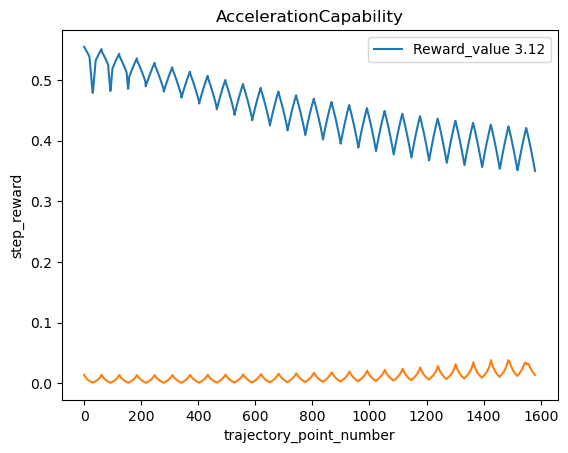

In [33]:
fixed_robot, free_robot = jps_graph2pinocchio_robot(problem.graph, builder=builder)

reward_decomposition = best_reward_decomposition[0]
trajectory_id = int(reward_decomposition[0])
trajectory = rewards_and_trajectories[0][1][trajectory_id]

point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)

reward, reward_list = acceleration_capability.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)
reward_vector = np.array(reward_list)
plt.plot(reward_vector)
plt.xlabel('trajectory_point_number')
plt.ylabel('step_reward')
plt.title('AccelerationCapability')
plt.legend([f'Reward_value {round(reward,2)}'])
#plt.show()

reward_decomposition = best_reward_decomposition[0]
trajectory_id = int(reward_decomposition[0])
trajectory = rewards_and_trajectories[0][1][trajectory_id]

point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)

reward, reward_list = heavy_lifting.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)
reward_vector = np.array(reward_list)
plt.plot(reward_vector/300)
plt.xlabel('trajectory_point_number')
plt.ylabel('step_reward')
plt.title('AccelerationCapability')
plt.legend([f'Reward_value {round(reward,2)}'])
plt.show()

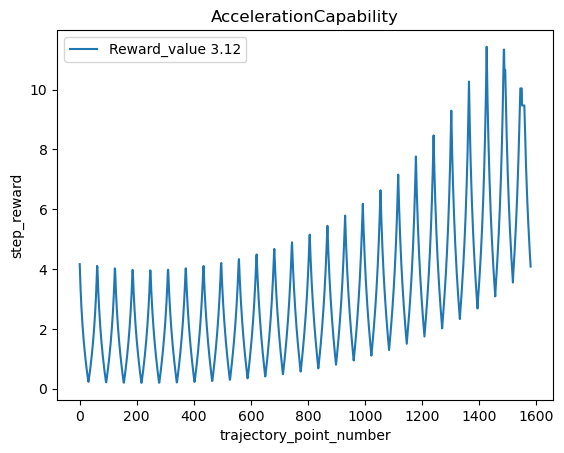

In [34]:
fixed_robot, free_robot = jps_graph2pinocchio_robot(problem.graph, builder=builder)

reward_decomposition = best_reward_decomposition[0]
trajectory_id = int(reward_decomposition[0])
trajectory = rewards_and_trajectories[0][1][trajectory_id]

point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)

reward, reward_list = heavy_lifting.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)
reward_vector = np.array(reward_list)
plt.plot(reward_vector)
plt.xlabel('trajectory_point_number')
plt.ylabel('step_reward')
plt.title('AccelerationCapability')
plt.legend([f'Reward_value {round(reward,2)}'])
plt.show()

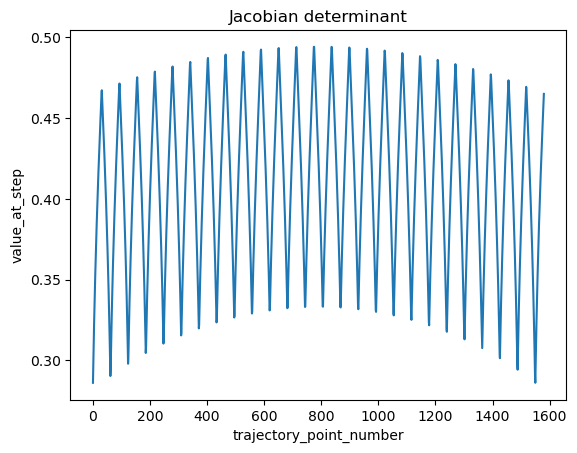

In [35]:
plt.plot(point_criteria_vector["MANIP"])
plt.xlabel('trajectory_point_number')
plt.ylabel('value_at_step')
plt.title('Jacobian determinant')
plt.show()

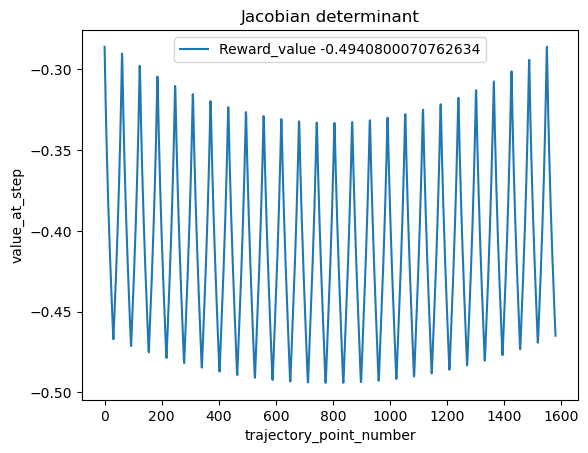

In [36]:
vector = np.linalg.det(point_criteria_vector["Manip_Jacobian"])


plt.plot(vector)
plt.xlabel('trajectory_point_number')
plt.ylabel('value_at_step')
plt.title('Jacobian determinant')
plt.legend([f'Reward_value {round(min(vector),5)}'])
plt.show()

In [37]:
print(len(reward_vector))
reward_vector=np.array(np.split(reward_vector, 51))
for i, _ in enumerate(reward_vector):
    if not i%2:
        reward_vector[i] = np.flip(reward_vector[i])


1581


In [38]:
reward_vector

array([[ 0.23899296,  0.30816014,  0.3787149 , ...,  3.578793  ,
         3.85288006,  4.16175992],
       [ 0.22695109,  0.29665727,  0.36772256, ...,  3.5400405 ,
         3.80594639,  4.10424478],
       [ 0.21670132,  0.28698217,  0.35859507, ...,  3.50891213,
         3.76779447,  4.05702627],
       ...,
       [ 3.54630783,  3.69277129,  3.84326307, ..., 10.6594171 ,
        10.6594171 , 10.6594171 ],
       [ 3.80321838,  3.95446399,  4.11002432, ..., 10.03893283,
        10.03893283, 10.03893283],
       [ 4.07913167,  4.23558044,  4.39666092, ...,  9.46808643,
         9.46808643,  9.46808643]])

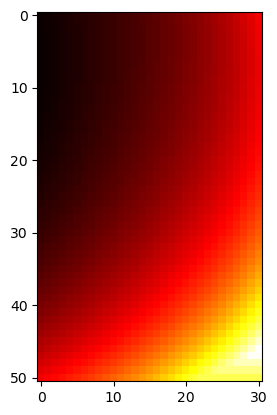

In [39]:
plt.imshow(reward_vector, cmap='hot', interpolation='nearest')
plt.show()


<Axes: >

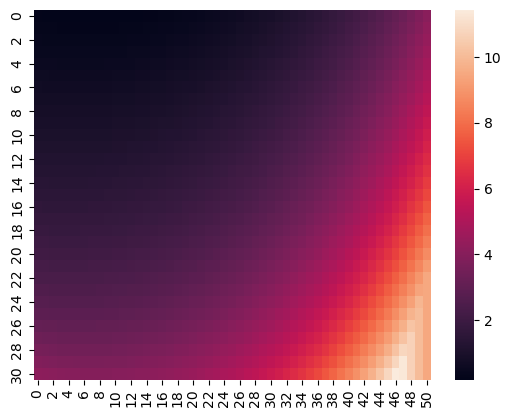

In [40]:
import seaborn as sns
reward_vector = reward_vector.T
sns.heatmap(reward_vector)